## Online CNMF-E

This demo shows an example of doing online analysis on one-photon data. We compare offline and online approaches. The dataset used is courtesy of the Miniscope project.

In [109]:
import bokeh.plotting as bpl
import holoviews as hv
import logging
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import caiman as cm
from caiman.source_extraction import cnmf as cnmf
from caiman.motion_correction import MotionCorrect
from caiman.utils.utils import download_demo
from caiman.utils.visualization import nb_inspect_correlation_pnr

from pathlib import Path
logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)10s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

bpl.output_notebook()
# hv.notebook_extension('bokeh')
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['legend.edgecolor'] = 'white'
plt.rcParams['legend.facecolor'] = 'black'

sns.set(rc={'axes.facecolor': 'black', 'grid.color': 'grey'})

def set_matplotlib_bg(bg='black'):
    color = 'white' if bg == 'black' else 'black'
    plt.rcParams['axes.facecolor'] = bg
    plt.rcParams['axes.edgecolor'] = color
    plt.rcParams['axes.labelcolor'] = color
    plt.rcParams['xtick.color'] = color
    plt.rcParams['ytick.color'] = color
    plt.rcParams['text.color'] = color
    plt.rcParams['grid.color'] = 'grey' if bg == 'black' else 'black'
    plt.rcParams['legend.edgecolor'] = color
    plt.rcParams['legend.facecolor'] = bg

Loading BokehJS ...

### Select file(s) to be processed
The `download_demo` function will download the specific file for you and return the complete path to the file which will be stored in your `caiman_data` directory. If you adapt this demo for your data make sure to pass the complete path to your file(s). Remember to pass the `fnames` variable as a list. Note that the memory requirement of the offline CNMF-E algorithm are much higher compared to the standard CNMF algorithm. One of the benefits of the online approach is the reduced memory requirements.

In [87]:
fnames = [Path.home() / 'data' / 'ca' / 'Spatial_downsam.tiff']
m_orig = cm.load_movie_chain(fnames)

100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


In [92]:
m_orig.play(fr=60, magnification=2)

## Batch (offline) approach

We start with motion correction and then proceed with the source extraction using the CNMF-E algorithm. For a detailed 1p demo check `demo_pipeline_cnmfE.ipynb`.

In [111]:
# motion correction parameters
motion_correct = True            # flag for performing motion correction
pw_rigid = False                 # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (3, 3)               # size of high pass spatial filtering, used in 1p data
border_nan = 'copy'              # replicate values along the boundaries
p = 1                            # order of the autoregressive system for GCamP - s 
niter_rig = 1        # number of iterations for rigid motion correction
max_shifts = (6, 6)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
splits_rig =  56     # for parallelization split the movies in  num_splits chuncks across time
                     # if none all the splits are processed and the movie is saved
#num_splits_to_process_rig = None  # intervals at which patches are laid out for motion correction
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between pathes (size of patch strides+overlaps)
splits_els =  56     # for parallelization split the movies in  num_splits chuncks across time
#num_splits_to_process_els = [28, None]
upsample_factor_grid = 4  # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
offset_mov = np.min(m_orig[:100]) # minimum of the movie
mc_dict = {
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'border_nan': border_nan,
    'niter_rig': niter_rig,
    'splits_rig': splits_rig,
    'strides': strides,
    'overlaps': overlaps,
    'splits_els': splits_els,
    'upsample_factor_grid': upsample_factor_grid,
    'max_deviation_rigid': max_deviation_rigid,
    'offset_mov': offset_mov
}

opts = cnmf.params.CNMFParams(params_dict=mc_dict)

   241711097 [params.py:change_params():1067] [28828] No parameter offset_mov found!


In [69]:
##%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

   134257803 [movies.py:extract_shifts():339] [28828] Movie average is negative. Removing 1st percentile.
   134257809 [movies.py:extract_shifts():357] [28828] Movie average is negative. Removing 1st percentile.
   134258034 [movies.py:extract_shifts():339] [28828] Movie average is negative. Removing 1st percentile.
   134258038 [movies.py:extract_shifts():357] [28828] Movie average is negative. Removing 1st percentile.
   134258280 [movies.py:extract_shifts():339] [28828] Movie average is negative. Removing 1st percentile.
   134258284 [movies.py:extract_shifts():357] [28828] Movie average is negative. Removing 1st percentile.


Decode mmap filename C:\Users\Thomas\data\ca\Spatial_downsam_rig__d1_200_d2_239_d3_1_order_F_frames_24639.mmap


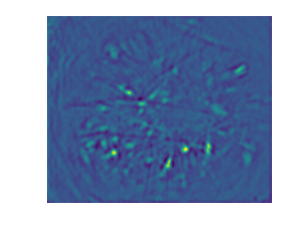

In [70]:
if motion_correct:
    # do motion correction rigid
    mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
    mc.motion_correct(save_movie=True)
    fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
    if pw_rigid:
        bord_px = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                     np.max(np.abs(mc.y_shifts_els)))).astype(int)
    else:
        bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(int)
        plt.subplot(1, 2, 1); plt.imshow(mc.total_template_rig, cmap=plt.get_cmap('coolwarm'))

    bord_px = 0 if border_nan == 'copy' else bord_px
    fname_new = cm.save_memmap(fname_mc, base_name='sept3_2_memmap_', order='C',
                               border_to_0=bord_px)
else:  # if no motion correction just memory map the file
    fname_new = cm.save_memmap(fnames, base_name='sept3_2_memmap_',
                               order='C', border_to_0=0, dview=dview)

### inspect motion correction results

In [110]:
 # plot rigid shifts
plt.figure(figsize=(20, 10))
shiftsize = np.round(len(mc.shifts_rig)/50, 0)
plt.plot(mc.shifts_rig[:3000]) 
plt.legend(['x shifts', 'y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')
plt.show()
# plt.savefig(Path.home() / 'data' / f'shifts_3000_{np.random.randint(100000)}.png', transparent=True, bbox_inches='tight', pad_inches=0)

NameError: name 'int64' is not defined

<Figure size 2000x1000 with 0 Axes>

In [72]:
mc.motion_correct_pwrigid(save_movie=True, template=mc.total_template_rig)
m_els = cm.load(mc.fname_tot_els)


  0%|          | 0/1 [00:00<?, ?it/s]

Decode mmap filename C:\Users\Thomas\data\ca\Spatial_downsam_els__d1_200_d2_239_d3_1_order_F_frames_24639.mmap


100%|██████████| 1/1 [00:04<00:00,  4.44s/it]


In [85]:
m_orig = cm.load_movie_chain(fnames)
m_rig = cm.load(mc.fname_tot_rig)
downsample_ratio = 0.2

m_cat = cm.concatenate([
    m_orig.resize(1, 1, downsample_ratio),
    m_rig.resize(1, 1, downsample_ratio),
    m_els.resize(1, 1, downsample_ratio)
], axis=2)

  0%|          | 0/1 [00:00<?, ?it/s]

Decode mmap filename C:\Users\Thomas\data\ca\Spatial_downsam_rig__d1_200_d2_239_d3_1_order_F_frames_24639.mmap


100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


In [ ]:
savepath = Path.home() / 'data' / f'concatenated_movie.mp4'
m_cat.save('motion_corrected_movie.tif')

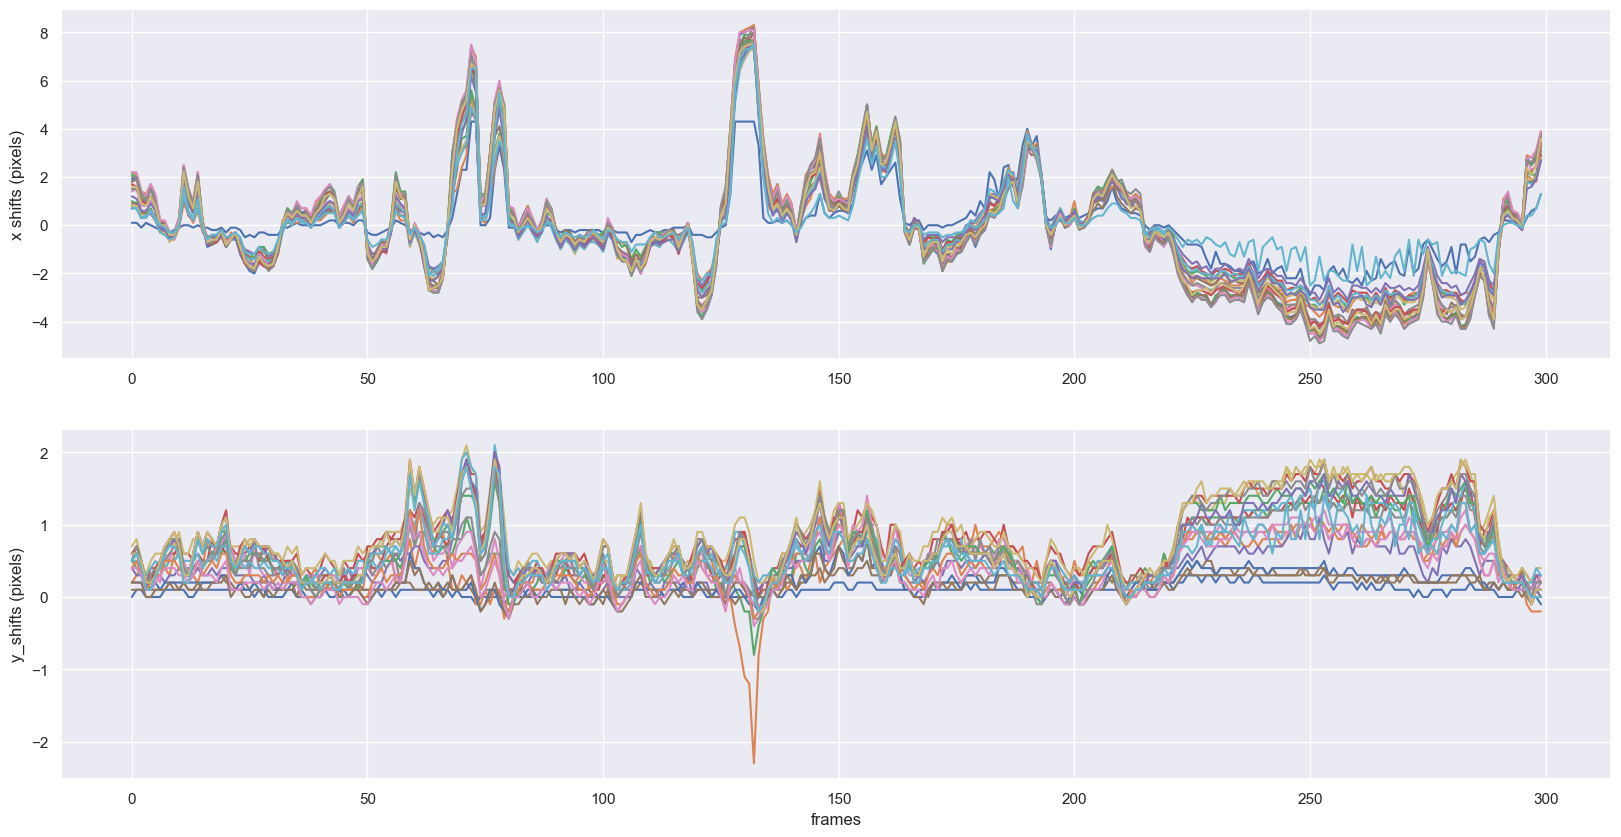

In [116]:
plt.close()
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(mc.x_shifts_els[:300])
plt.ylabel('x shifts (pixels)')
plt.subplot(2, 1, 2)
plt.plot(mc.y_shifts_els[:300])
plt.ylabel('y_shifts (pixels)')
plt.xlabel('frames')
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els[:300])),
                                 np.max(np.abs(mc.y_shifts_els[:300])))).astype(np.int32)
plt.show()
# plt.savefig(Path.home() / 'data' / f'shifts_3000_{np.random.randint(100000)}.png', transparent=True, bbox_inches='tight', pad_inches=0)

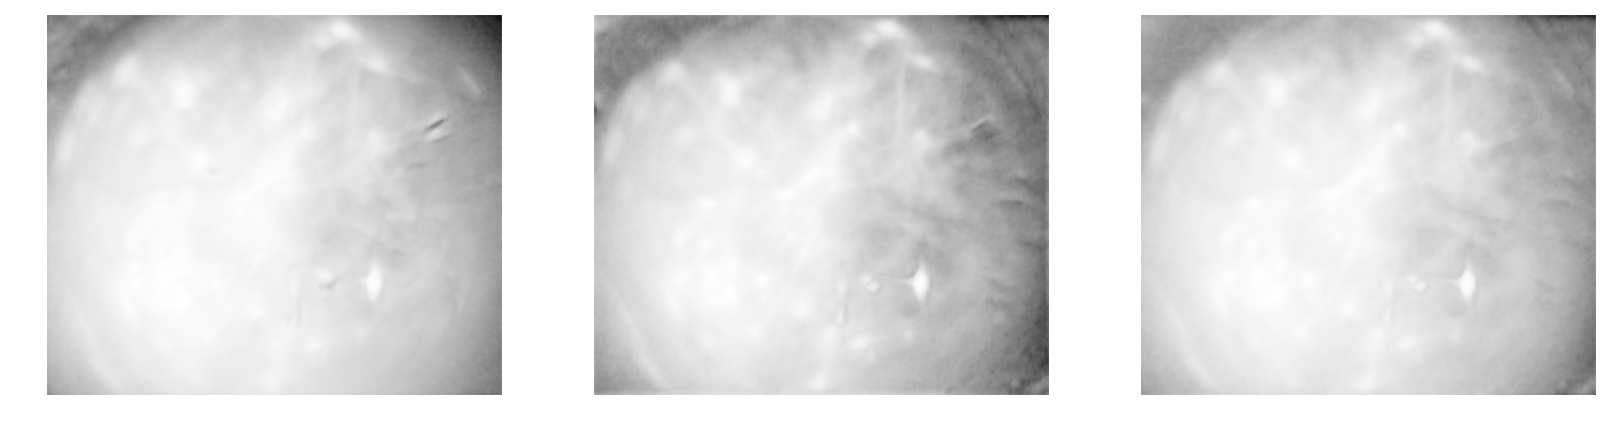

In [94]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1); plt.imshow(m_orig.local_correlations(eight_neighbours=True, swap_dim=False), cmap=plt.get_cmap('gray'))
plt.subplot(1,3,2); plt.imshow(m_rig.local_correlations(eight_neighbours=True, swap_dim=False), cmap=plt.get_cmap('gray'))
plt.subplot(1,3,3); plt.imshow(m_els.local_correlations(eight_neighbours=True, swap_dim=False), cmap=plt.get_cmap('gray'))
plt.show()
# plt.savefig(Path.home() / 'data' / f'local_correlations_{np.random.randint(100000)}.png', transparent=True, bbox_inches='tight', pad_inches=0)



In [127]:
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_orig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

Decode mmap filename C:\Users\Thomas\data\ca\Spatial_downsam_rig__d1_200_d2_239_d3_1_order_F_frames_24639.mmap
Decode mmap filename C:\Users\Thomas\data\ca\Spatial_downsam_els__d1_200_d2_239_d3_1_order_F_frames_24639.mmap


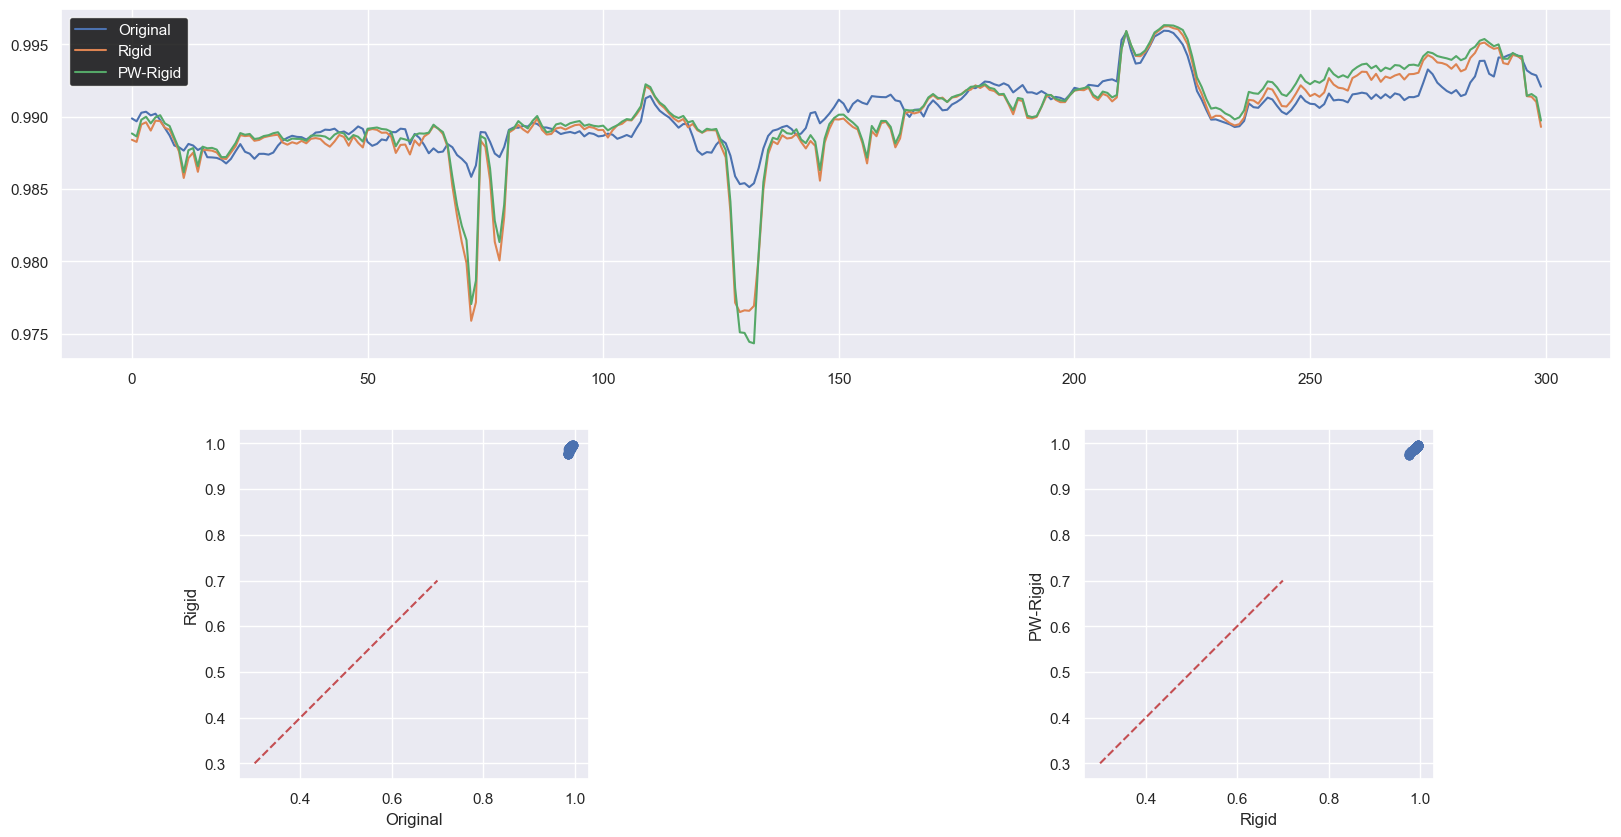

In [124]:
correlations_els = np.array(correlations_els[:3000])
correlations_rig = np.array(correlations_rig[:3000])
correlations_orig = np.array(correlations_orig[:3000])
plt.figure(figsize = (20,10))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); plt.plot(correlations_els)
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original')
plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square')
plt.subplot(224); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid') 
plt.ylabel('PW-Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); plt.axis('square')
plt.show()
# plt.savefig(Path.home() / 'data' / f'correlations_{np.random.randint(100000)}.png', transparent=True, bbox_inches='tight', pad_inches=0)

C:\Users\Thomas\data\ca\Spatial_downsam_els__d1_200_d2_239_d3_1_order_F_frames_24639.mmap
KeysView(NpzFile 'C:\\Users\\Thomas\\data\\ca\\Spatial_downsam_els__d1_200_d2_239_d3_1_order_F_frames_24639_metrics.npz' with keys: flows, norms, correlations, smoothness, tmpl...)
C:\Users\Thomas\data\ca\Spatial_downsam_els__d1_200_d2_239_d3_1_order_F_frames_24639_metrics.npz
18.73527+/-8.2724285 ; 1019.82404 ; 0.35146513830876247
Decode mmap filename C:\Users\Thomas\data\ca\Spatial_downsam_els__d1_200_d2_239_d3_1_order_F_frames_24639.mmap
KeysView(NpzFile 'C:\\Users\\Thomas\\data\\ca\\Spatial_downsam_rig__d1_200_d2_239_d3_1_order_F_frames_24639_metrics.npz' with keys: flows, norms, correlations, smoothness, tmpl...)
C:\Users\Thomas\data\ca\Spatial_downsam_rig__d1_200_d2_239_d3_1_order_F_frames_24639_metrics.npz
39.420315+/-21.759195 ; 1016.19464 ; 0.36474250777366646
Decode mmap filename C:\Users\Thomas\data\ca\Spatial_downsam_rig__d1_200_d2_239_d3_1_order_F_frames_24639.mmap


FileNotFoundError: [Errno 2] No such file or directory: '_metrics.npz'

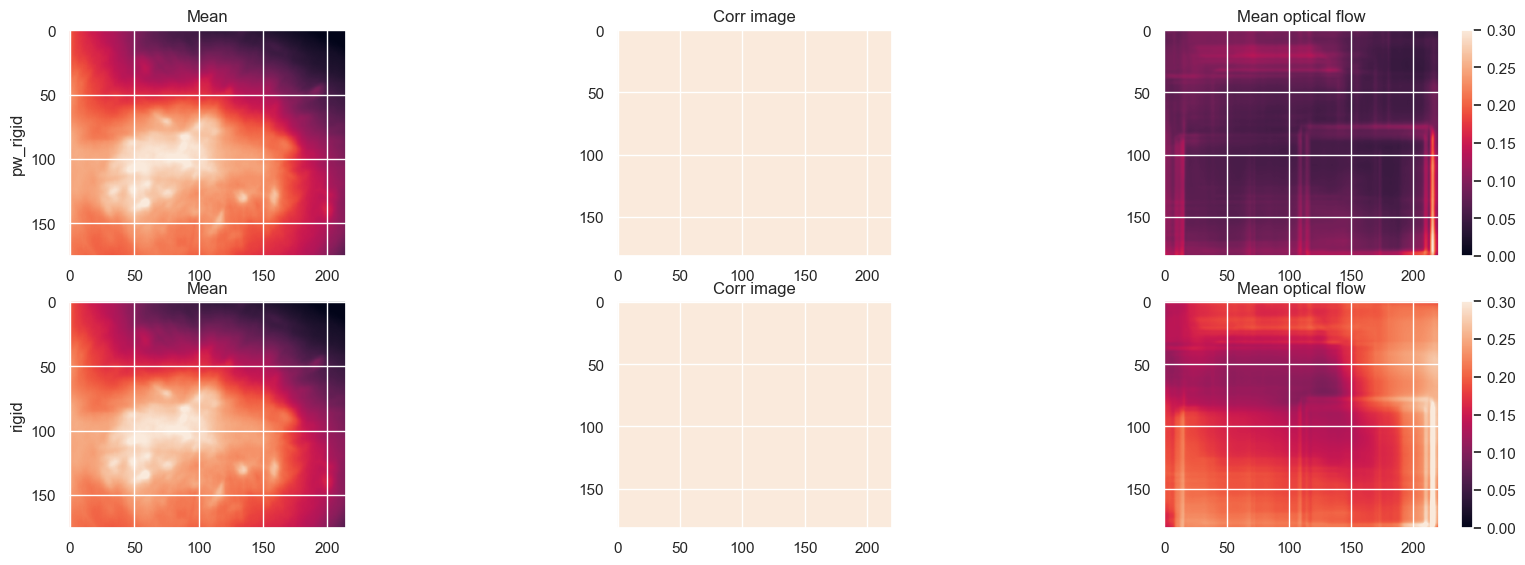

In [134]:
fname_tot_els_str = mc.fname_tot_els[0] if mc.fname_tot_els else ''
fname_tot_rig_str = mc.fname_tot_rig[0] if mc.fname_tot_rig else ''
fnames = str(fnames[0])

print(fname_tot_els_str)
# Now construct your 'fls' list
fls = [
    fname_tot_els_str[:-5] + '_metrics.npz',
    fname_tot_rig_str[:-5] + '_metrics.npz',
    fnames[0][:-5] + '_metrics.npz'
]

plt.figure(figsize=(20, 10))
for cnt, fl, metr in zip(range(len(fls)), fls, ['pw_rigid', 'rigid', 'raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))

        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        mean_img = np.mean(
            cm.load(fl[:-12] + '.mmap'), 0)[12:-12, 12:-12]
  

        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        #plt.plot(ld['norms'])
        #plt.xlabel('frame')
        #plt.ylabel('norm opt flow')
        #plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
            np.sqrt(flows[:, :, :, 0] ** 2 + flows[:, :, :, 1] ** 2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow')

In [ ]:
template = cm.load(fname_new)
# load memory mappable file
A = cm.load_memmap(fname_new)
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

# 
# # Plot rigid template
# plt.figure(figsize=(20, 10))
# plt.imshow(template[,:,:], cmap='gray')
# plt.title('Rigid Template')
# plt.axis('off')  # Turn off axis
# 
# # Save the figure
# output_path1 = Path.home() / 'data' / f'rigid_template_{np.random.randint(100000)}.png'
# plt.savefig(output_path1, transparent=True, bbox_inches='tight', pad_inches=0)
# plt.close()
# 
# # Plot mean frame of rigidly registered movie
# plt.figure(figsize=(20, 10))
# plt.imshow(template[,:,:].mean(), cmap='gray')
# plt.title('Mean Frame of Rigidly Registered Movie')
# plt.axis('off')  # Turn off axis

# Save the figure
output_path2 = Path.home() / 'data' / f'mean_frame_rigid_{np.random.randint(100000)}.png'
plt.savefig(output_path2, transparent=True, bbox_inches='tight', pad_inches=0)
plt.close()


### Run CNMF-E on patches

In [ ]:

inspect_results = True
if inspect_results:
    cm.concatenate((cm.load(fnames), cm.load(mc.mmap_file)), axis=1).play()
plt.figure()
plt.plot(mc.shifts_rig)
plt.legend(['x-shifts', 'y-shifts'])    

The motion correction results look good. We then proceed with memory mapping and checking the correlation/pnr images.

In [ ]:
fname_new = cm.save_memmap(mc.mmap_file, base_name='memmap_', order='C',
                           border_to_0=0, dview=dview)
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

### Inspect correlation and PNR images to set relevant thresholds

In [ ]:
gSig = (6, 6)

cn_filter, pnr = cm.summary_images.correlation_pnr(images[::max(T//1000, 1)], gSig=5, swap_dim=False) 
cm.estimates.coordinates = None
cnm.estimates.plot_contours_nb(img=cn_filter, thr=.6);
nb_inspect_correlation_pnr(cn_filter, pnr)

## Set parameters for source extraction
From the images above we select `min_pnr = 10` and `min_corr = 0.8`. We pass these alongside the other parameters needed for offline 1p processing.

In [ ]:
min_pnr = 10
min_corr = 0.8
rf = 48                                        # half size of each patch
stride = 8                                     # amount of overlap between patches     
ssub = 1                                       # spatial downsampling factor   
decay_time = 0.4                               # length of typical transient (in seconds)
fr = 10                                        # imaging rate (Hz) 
gSig = (6, 6)                                  # expected half size of neurons
gSiz = (15, 15)                                # half size for neuron bounding box   
p = 0                                          # order of AR indicator dynamics
min_SNR = 1.5                                  # minimum SNR for accepting new components
rval_thr = 0.85                                # correlation threshold for new component inclusion
merge_thr = 0.65                               # merging threshold
K = None                                       # initial number of components

cnmfe_dict = {'fnames': fnames,
              'fr': fr,
              'decay_time': decay_time,
              'method_init': 'corr_pnr',
              'gSig': gSig,
              'gSiz': gSiz,
              'rf': rf,
              'stride': stride,
              'p': p,
              'nb': 0,
              'ssub': ssub,
              'min_SNR': min_SNR,
              'min_pnr': min_pnr,
              'min_corr': min_corr,
              'bas_nonneg': False,
              'center_psf': True,
              'rval_thr': rval_thr,
              'only_init': True,
              'merge_thr': merge_thr,
              'K': K}
opts.change_params(cnmfe_dict);

In [ ]:
from time import time
t1 = -time()
cnm = cnmf.CNMF(n_processes=n_processes, dview=dview, params=opts)
cnm.fit(images)
t1 += time()

## View the results

In [ ]:
cnm.estimates.plot_contours_nb(img=pnr)

In [ ]:
cnm.estimates.nb_view_components(img=cn_filter)

### Show a movie with the results

In [ ]:
cnm.estimates.play_movie(images, magnification=0.75, include_bck=False)

# Online Processing
Now try the online approach. The idea behind the online algorithm is simple:
- First initialize the estimates by running the batch (offline) algorithm in small subset.
- Then process each frame as it arrives. The processing consists of:
    * Motion correct the new frame
    * Extract the activity of existing neurons at this frame, and neuropil
    * Search for new neurons that appear in this frame and have not been detected earlier.
- Periodically update shapes of existing neurons and background model.

## Setup additional parameters for online processing

In [ ]:
from copy import deepcopy
online_opts = deepcopy(cnm.params)

In [ ]:
rf = 48                                        # half size of patch (used only during initialization)
stride = 8                                     # overlap between patches (used only during initialization) 
ssub = 1                                       # spatial downsampling factor (during initialization)
ds_factor = 2*ssub                             # spatial downsampling factor (during online processing)         
ssub_B = 4                                     # background downsampling factor (use that for faster processing)
gSig = (10//ds_factor, 10//ds_factor)          # expected half size of neurons
gSiz = (22//ds_factor, 22//ds_factor)
sniper_mode = False                            # flag using a CNN to detect new neurons (o/w space correlation is used)
init_batch = 300                               # number of frames for initialization (presumably from the first file)
expected_comps = 500                           # maximum number of expected components used for memory pre-allocation (exaggerate here)
dist_shape_update = False                      # flag for updating shapes in a distributed way
min_num_trial = 5                              # number of candidate components per frame     
K = None                                       # initial number of components
epochs = 2                                     # number of passes over the data
show_movie = False                             # show the movie with the results as the data gets processed
use_corr_img = True                            # flag for using the corr*pnr image when searching for new neurons (otherwise residual)

online_dict = {'epochs': epochs,
               'nb': 0,
               'ssub': ssub,
               'ssub_B': ssub_B,
               'ds_factor': ds_factor,                                   # ds_factor >= ssub should hold
               'gSig': gSig,
               'gSiz': gSiz,
               'gSig_filt': (3, 3),
               'min_corr': min_corr,
               'bas_nonneg': False,
               'center_psf': True,
               'max_shifts_online': 20,
               'rval_thr': rval_thr,
               'motion_correct': True,
               'init_batch': init_batch,
               'only_init': True,
               'init_method': 'cnmf',
               'normalize_init': False,
               'update_freq': 200,
               'expected_comps': expected_comps,
               'sniper_mode': sniper_mode,                               # set to False for 1p data       
               'dist_shape_update' : dist_shape_update,
               'min_num_trial': min_num_trial,
               'epochs': epochs,
               'use_corr_img': use_corr_img,
               'show_movie': show_movie}
online_opts.change_params(online_dict);

In [ ]:
cnm_online = cnmf.online_cnmf.OnACID(params=online_opts, dview=dview)
cnm_online.fit_online()

In [ ]:
#images = cm.load(fnames[0], subindices=slice(0,1000))
#Cn, pnr = cm.summary_images.correlation_pnr(images[::1], gSig=gSig[0], swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
cnm_online.estimates.nb_view_components(img=pnr, denoised_color='red');

In [ ]:
cnm_online.estimates.plot_contours_nb(img=pnr)

## Plot timing
The plot below shows the time spent on each part of the algorithm (motion correction, tracking of current components, detect new components, update shapes) for each frame. Note that if you displayed a movie while processing the data (`show_movie=True`) the time required to generate this movie will be included here.

In [ ]:
show_cumulative = True
#if show_cumulative:
T_init = np.array([cnm_online.t_init] + [0]*(epochs*T-1))
T_motion = 1e3*np.array([0]*init_batch + cnm_online.t_motion)/1e3
T_detect = 1e3*np.array([0]*init_batch + cnm_online.t_detect)/1e3
T_shapes = 1e3*np.array([0]*init_batch + cnm_online.t_shapes)/1e3
T_online = 1e3*np.array([0]*init_batch + cnm_online.t_online)/1e3 - T_motion - T_detect - T_shapes
plt.figure()
plt.stackplot(np.arange(len(T_motion)), np.cumsum(T_init), np.cumsum(T_motion), np.cumsum(T_online), np.cumsum(T_detect), np.cumsum(T_shapes))
plt.legend(labels=['init', 'motion', 'process', 'detect', 'shapes'], loc=2)
for i in range(epochs - 1):
    plt.plot([(i+1)*T, (i+1)*T], [0, np.array(cnm_online.t_online).sum()+cnm_online.t_init], '--k')
plt.title('Processing time allocation')
plt.xlabel('Frame #')
plt.ylabel('Processing time [ms]')
#plt.ylim([0, 1.2e3*np.percentile(np.array(cnm_online.t_online), 90)]);

In [ ]:
cnm_online.estimates.play_movie(imgs=images, magnification=0.75, include_bck=False)

## Clean up and compare two approaches

Even though the online algorithm screens any new components, we can still perform the quality tests to filter out any false positive components. To do that, we first need to apply the inferred shifts to the original data in order to have the whole registered dataset in memory mapped form.

In [ ]:
if online_opts.online['motion_correct']:
    shifts = cnm_online.estimates.shifts[-cnm_online.estimates.C.shape[-1]:]
    if not opts.motion['pw_rigid']:
        memmap_file = cm.motion_correction.apply_shift_online(images, shifts,
                                                              save_base_name='MC')
    else:
        mc = MotionCorrect(fnames, dview=dview, **online_opts.get_group('motion'))

        mc.y_shifts_els = [[sx[0] for sx in sh] for sh in shifts]
        mc.x_shifts_els = [[sx[1] for sx in sh] for sh in shifts]
        memmap_file = mc.apply_shifts_movie(fnames, rigid_shifts=False,
                                            save_memmap=True,
                                            save_base_name='MC')
else:  # To do: apply non-rigid shifts on the fly
    memmap_file = images.save(fnames[0][:-4] + 'mmap')
cnm_online.mmap_file = memmap_file
Yr_online, dims, T = cm.load_memmap(memmap_file)

#cnm_online.estimates.dview=dview
#cnm_online.estimates.compute_residuals(Yr=Yr_online)
images_online = np.reshape(Yr_online.T, [T] + list(dims), order='F')
min_SNR = 2  # peak SNR for accepted components (if above this, acept)
rval_thr = 0.85  # space correlation threshold (if above this, accept)
use_cnn = False  # use the CNN classifier
cnm_online.params.change_params({'min_SNR': min_SNR,
                                'rval_thr': rval_thr,
                                'use_cnn': use_cnn})

cnm_online.estimates.evaluate_components(images_online, cnm_online.params, dview=dview)
cnm_online.estimates.Cn = pnr

In [ ]:
cnm_online.estimates.plot_contours_nb(img=pnr, idx=cnm_online.estimates.idx_components)

In [ ]:
cnm_online.estimates.hv_view_components(img=pnr, idx=cnm_online.estimates.idx_components,
                                        denoised_color='red')

In [ ]:
cnm_online.estimates.hv_view_components(img=pnr, idx=cnm_online.estimates.idx_components_bad,
                                        denoised_color='red')

## Difference in inferred shifts

Accurate motion correction is important for the online algorithm. Below we plot the difference in the estimated shifts between the two approaches. Note that the online shifts have been rescaled by a factor of `ds_factor`.

In [ ]:
plt.plot(np.array(mc.shifts_rig) - ds_factor*np.array(cnm_online.estimates.shifts[:1000]));
plt.legend(['x-shifts', 'y-shifts']);
plt.title('Difference between offline and online shifts')
plt.xlabel('Frame #')
plt.ylabel('pixels')

Constant shifts in the FOV will not significantly affect the results. What is most important is deviatons. 

In [ ]:
np.std(np.array(mc.shifts_rig) - ds_factor*np.array(cnm_online.estimates.shifts[:1000]), axis=0)

The standard deviation is at a subpixel level (although it can still be significant). The high degree of similarity can also be seen from the correlation between the shifts of the two approaches.

In [ ]:
np.corrcoef(np.array(mc.shifts_rig).T, np.array(cnm_online.estimates.shifts[:1000]).T)